In [531]:
from skimage.filters import threshold_local #scikit-image é uma coleção de algoritmos para processamento de imagem
from skimage import measure
import imutils
import base64 #nos permite converter bytes contendo dados binários ou de texto em caracteres ASCII
import os #modulo que fornece funções para interagir com o sistema operacional
import random as rng
import pytesseract
import re 
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,7)

In [532]:
#definindo constantes

W = 800
cleanText = r"[^A-Z0-9.,\-\s\/]" #regex para eliminar caracteres indesejados

In [533]:
def cleanImage(image, stage = 0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # aplicando as operações topHat/blackHat
    topHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel) #revela as áreas claras com fundo escuro
    blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel) #revela as áreas escuras com um fundo claro
    # fazendo adição e subtração entre as operações morfológicas
    add = cv2.add(gray, topHat)
    subtract = cv2.subtract(add, blackHat)
    if (stage == 1):
        return subtract
    T = threshold_local(subtract, 29, offset=35, method="gaussian", mode="mirror")
    thresh = (subtract > T).astype("uint8") * 255
    if (stage == 2):
        return thresh
    # inverte a imagem 
    thresh = cv2.bitwise_not(thresh)
    return thresh

In [534]:
#seleciona as áreas de interesse, ou seja, as possíveis áreas que possuem dados 
def extractROIs(image, origin, minArea = 1800, minHeight = 25, minWidth = 22): #talvez precise mudar esse parametros de área, altura e largura
    # encontra os contornos na imagem
    cnts = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html
    cnts = imutils.grab_contours(cnts)#retorna contadores(contornos) em cnts
    roisAsRects = [] #ROIs como retas

#    testArray = []  
#     for j in cnts:
#         if len(j) >= 200:
#             testArray.append(j)
    
    img1 = cv2.drawContours(origin, cnts, -1, (0,255,0), 3)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()
    
    for c in cnts:
        rect = cv2.minAreaRect(c) #retângulo delimitador é desenhado com área mínima
        print("rect", rect)
        #box = cv2.boxPoints(rect)
        #box = np.int0(box)
        #imgtest = cv2.drawContours(origin,[box],-1,(0,0,255),3)
        #######################################
        x,y,w,h = cv2.boundingRect(c)
        print(x)
        print(y)
        print(w)
        print(h)
        imgtest = cv2.rectangle(origin,(x,y),(x+w,y+h),(0,0,255),2)
        plt.imshow(cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB))
        plt.show()
        #######################################
        (_, _),(rw, rh),_ = rect #pega o retorno do minAreaRect que é = canto superior esquerdo(x,y), (largura,altura), angulo de rotação
        if (rh > 0):
            ratio = float(rh)/rw #calcula a razão
            print("ratio: ", ratio)
            area = rw*rh
            print("area: ", area)
            if (area > minArea and rh > minHeight and rw > minWidth and (ratio > 1 or ratio < 0.5)):
                #adiciona a lista de rois
                roisAsRects.append(rect)
        return roisAsRects
    #não usa origin ??

In [535]:
def rect2Box(rect):
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    return box #retorna 4 arrays [x,y], representando os 4 pontos da caixa

#ajusta e refina as ROIs
def cropRois(image, rects, multHeight = 0.73, multWidth = 0.97, topHeightCrop = 30): #parametros (????) 
    crops = []
    data = {}
    angles = []

    for r in rects:
        box = rect2Box(r)
        W = r[1][0]
        H = r[1][1]

        Xs = [i[0] for i in box]
        Ys = [i[1] for i in box]
        x1 = min(Xs)
        x2 = max(Xs)
        y1 = min(Ys)
        y2 = max(Ys)

        rotated = False
        angle = r[2]

        if angle < -45:
            angle += 90
            rotated = True

        # calc the centroid
        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
        size = (int((x2-x1)), int((y2 - y1)))
        #cv2.circle(image, center, 2, 255, -1)

        M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1.0)

        # prepare the crop
        cropped = cv2.getRectSubPix(image, size, center)
        cropped = cv2.warpAffine(cropped, M, size)
        croppedW = W if not rotated else H 
        croppedH = H if not rotated else W

        ratio = float(croppedW) / (croppedH)
        area = float(croppedW) * croppedH

        # if in the ratio
        if (ratio > 2 and ratio < 16):
            #text = "{0:.2f}-{1:.2f} ".format(ratio, area)
            #cv2.putText(image, text, center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW * multWidth), int(croppedH * multHeight if croppedH < topHeightCrop else croppedH * 0.9)), (size[0] / 2, size[1] / 2))
            # save the angles to calc the avg/std
            angles.append(angle)
            # save the crops
            crops.append(croppedRotated)
            # will process from top to bottom, so save it to sort later
            data[y1] = [croppedRotated, area, ratio, angle]

    return data, np.mean(np.array(angles)), np.std(np.array(angles))

In [536]:
img = cv2.imread("alinhadas/ImagemNova00.jpg")
#img = cv2.imread("fake_cnh.png")
resize_proc = imutils.resize(img, width=W) #seria a imagem alinhada
resize_orig = imutils.resize(img, width=W)

In [537]:
#limpando imagem 
clean = cleanImage(resize_proc)
#plt.imshow(cv2.cvtColor(clean, cv2.COLOR_BGR2RGB))
#plt.show()

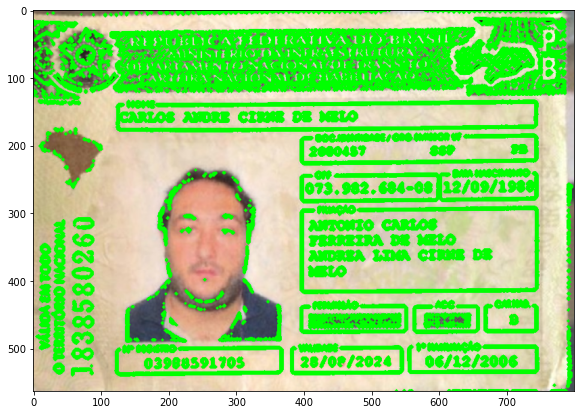

rect ((726.0, 562.0), (36.0, 0.0), 180.0)
708
562
37
1


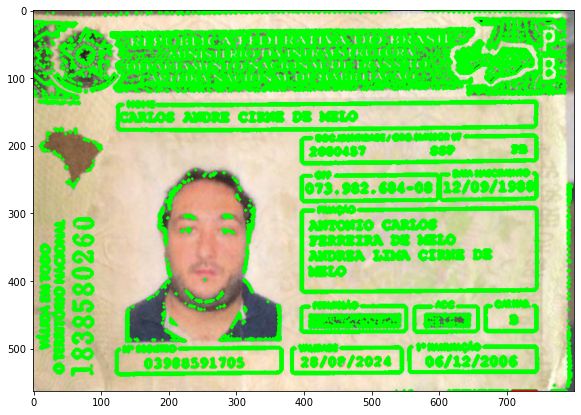

[]


In [538]:
#extraindo rois
rrects = extractROIs(clean, resize_orig, 1000, 25, 22)
print(rrects)

In [539]:
#processa as ROIs
rois, meanAngle, stdAngle = cropRois(resize_orig, rrects)
print(rois)
print(meanAngle)
print(stdAngle)

{}
nan
nan
